<a href="https://colab.research.google.com/github/dkalenov/Gym-Customer-Churn-Prediction/blob/main/Gym_Customer_Churn_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of gym customer churn. Prediciton models

Fitness center chains need to:

- predict the likelihood of customer churn;
- form typical user profiles;
- identify the main signs that most strongly influence the churn.

### Description [data](https://raw.githubusercontent.com/obulygin/content/main/gym_churn/gym_churn.csv)

- 'Churn' — fact of outflow in the current month;
- 'gender'
- 'Near_Location' - living or working in the area where the fitness center is located
- 'Partner' - employee of the club's partner company
- 'Promo_friends' - the fact of the initial entry as part of the "bring a friend" promotion
- 'Phone'—presence of contact phone number
- 'Age'
- 'Lifetime' - time from the moment of the first visit to the fitness center (in months)
- 'Contract_period' — duration of the current active subscription (month, 3 months, 6 months, year)
- 'Month_to_end_contract' - period until the end of the current active subscription (in months)
- 'Group_visits' - fact of visiting group classes
- 'Avg_class_frequency_total' - average frequency of visits per week for the entire time since the start of the subscription
- 'Avg_class_frequency_current_month' - average frequency of visits per week for the previous month
- 'Avg_additional_charges_total' - total revenue from other services of the fitness center: cafes, sporting goods, etc.

Tasks:
1. Check the data for problems (missing/errors/incorrect values);
2. EDA. Study distributions, relationships;
3. Select and build a customer churn forecasting model. Quality metric: recall, because it is important to minimize the number of false negatives (when a client leaves, but the model predicts that he will stay);
4. Perform user clustering. Make a portrait of each cluster, and formulate brief conclusions for each of them, based on their specifics and churns.



# Def

In [1]:
# Function for displaying basic information about the dataset

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def basic_data_preprocessing(dataframe):
    # Convert all column titles to lowercase with "_" between words
    dataframe.columns = [x.lower().replace(' ', '_') for x in dataframe.columns.values]

    # Basic information about the dataset
    rows_num, columns_num = dataframe.shape
    print(f'Number of records: {rows_num}')
    print(f'Number of columns: {columns_num}\n')
    print('-' * 75)

    # Dataset information
    print("\nDataset Information:")
    display(dataframe.info())
    print()
    print('-' * 75)

    # Checking for missing values
    missing_values = dataframe.isnull().sum()
    if missing_values.sum() > 0:
        print("Missing values:")
        display(pd.DataFrame(missing_values, columns=['Missing Count']))
        display(dataframe[dataframe.isna().any(axis=1)])
    else:
        print("No missing values.")
    print('-' * 75)

    # Checking for zero-filled columns
    zero_columns = dataframe.columns[(dataframe == 0.0).any()]
    zero_count = dataframe[zero_columns].apply(lambda x: x.value_counts().get(0, 0))
    if zero_count.sum() != 0:
        print('Rows with value 0 found:')
        display(pd.DataFrame(zero_count, columns=['Zero Count']))
    else:
        print('No rows with value 0.')
    print('-' * 75)

    # Checking for duplicates
    if dataframe.duplicated().sum() > 0:
        print("Duplicate data found. Number of duplicates:", dataframe.duplicated().sum())
        display(dataframe[dataframe.duplicated(keep=False)])
    else:
        print("No duplicates found.")
    print('-' * 75)

    # Checking for negative values in the dataframe
    # Excluding columns with string data type (object type)
    dataframe_digits = dataframe.select_dtypes(exclude=['object'])
    if (dataframe_digits < 0).sum().sum() > 0:
        print("Negative values found:")
        display(pd.DataFrame((dataframe_digits < 0).sum(), columns=['Negative Value Count']))
    else:
        print('No negative values found.')
    print('-' * 75)

    # Statistical description of the data
    print("\nStatistical Description of the Data:\n")
    display(dataframe.describe())
    print('-' * 75)

    # Data Distribution
    print("\nData Distribution:")

    # Determine the number of graphs and rows for the subplots
    num_graphs = len(dataframe.columns)
    num_rows = (num_graphs + 1) // 2
    fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, num_rows * 4))

    for i, column in enumerate(dataframe.columns):
        ax = axes[i // 2, i % 2]  # Get the current axis from the subplot grid

        # Categorical feature: countplot
        if dataframe[column].dtype == 'object':
            sns.countplot(data=dataframe, x=column, ax=ax, color='dodgerblue')
            ax.tick_params(axis='x')
            total = float(len(dataframe[column]))
            for p in ax.patches:
                height = p.get_height()
                ax.annotate(f'{height/total:.2%}', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom')

        # Numeric feature with less than 8 unique values: countplot
        else:
            if len(dataframe[column].unique()) < 8:
                sns.countplot(data=dataframe, x=column, ax=ax, color='dodgerblue')
                ax.tick_params(axis='x')
                total = float(len(dataframe[column]))
                for p in ax.patches:
                    height = p.get_height()
                    ax.annotate(f'{height/total:.2%}', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom')
            else:
                sns.histplot(data=dataframe, x=column, kde=True, ax=ax, color='dodgerblue')
                ax.axvline(dataframe[column].mean(), color='red', linestyle='--')
        # Set visualization properties for the current axis
        ax.grid(False)
        ax.set_title(column)
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        ax.set_facecolor('white')
        ax.tick_params(top=False, bottom=False, left=False, right=False)

    # Adjust the layout and display the plot
    plt.tight_layout()
    plt.show()

In [2]:
# Function for compression of the data type of columns in a pandas DataFrame

import pandas as pd
import numpy as np

def data_type_compression(dataframe):

    for column in dataframe.columns:
        unique_values = dataframe[column].unique()

        # Check if the column has two unique values (potentially a boolean column)
        # Uncomment the code below if you want to convert such columns to boolean type
        # if len(unique_values) == 2:
        #   dataframe[column] = dataframe[column].astype(bool)

        # Check if the column has an integer data type
        if dataframe[column].dtype == int:
            max_value = np.max(dataframe[column])

            # Assign the appropriate integer type based on the maximum value in the column
            if max_value <= np.iinfo(np.int8).max:
                dataframe[column] = dataframe[column].astype(np.int8)
            elif max_value <= np.iinfo(np.int16).max:
                dataframe[column] = dataframe[column].astype(np.int16)
            elif max_value <= np.iinfo(np.int32).max:
                dataframe[column] = dataframe[column].astype(np.int32)
            else:
                dataframe[column] = dataframe[column].astype(np.int64)

        # Check if the column has a float data type
        elif dataframe[column].dtype == float:
            max_value = np.max(dataframe[column])

            # Assign the appropriate float type based on the maximum value in the column
            if max_value <= np.finfo(np.float16).max:
                dataframe[column] = dataframe[column].astype(np.float16)
            elif max_value <= np.finfo(np.float32).max:
                dataframe[column] = dataframe[column].astype(np.float32)
            else:
                dataframe[column] = dataframe[column].astype(np.float64)


In [3]:
# Function for visualizing the distribution of different features by a target feature

import matplotlib.pyplot as plt
import seaborn as sns

def data_distribution_by_target(dataframe, target_feature):

  for column in dataframe.columns:
        plt.figure(figsize=(6, 4))
        sns.set_style("whitegrid", {'axes.grid': False})

        # Categorical feature: barplot
        if dataframe[column].dtype == 'object':
            plt.xticks(rotation=45)
            sns.barplot(x=column, y=target_feature, data=dataframe)  # Plot a barplot of the feature and target_variable

        # Date/time feature: lineplot
        elif dataframe[column].dtype == 'datetime64[ns]':
            plt.xticks(rotation=45)
            sns.lineplot(x=column, y=target_feature, data=dataframe)  # Plot a lineplot of the feature and target_variable

        # Numeric feature: histogram with kernel density estimation (kde)
        elif dataframe[column].dtype in ['float64', 'float32', 'float16']:
            sns.histplot(data=dataframe, x=column, hue=target_feature, kde=True, multiple='stack', alpha=0.75)
            plt.axvline(x=dataframe[column].mean(), color='r', linestyle='--', linewidth=2)  # Add a vertical line at the mean value

        # Other feature types: histogram or countplot

        else:
            if dataframe[column].nunique() > 6:
                sns.histplot(data=dataframe, x=column, hue=target_feature, multiple='stack', alpha=0.75)
                plt.xticks(rotation=45, ha='right')  # Rotate and align x-axis labels
                plt.axvline(x=dataframe[column].mean(), color='r', linestyle='--', linewidth=2)  # Add a vertical line at the mean value
            else:
                sns.countplot(data=dataframe, x=column, hue=target_feature)

        plt.xlabel(column)
        plt.ylabel('Count')

        if dataframe[column].dtype == 'object':
            plt.xticks(rotation=45, ha='right')  # Rotate and align x-axis labels

        plt.title(f'Data Distribution by {target_feature}: {column}')  # Add a title to the plot
        plt.tight_layout()  # Adjust the spacing of the plot elements
        plt.show()

In [4]:
# Function for detecting outliers in a dataframe
# Displays boxplots and a table with outlier information

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def detect_outliers(dataframe):
    outlier_table = pd.DataFrame(columns=['Column', 'Outlier Count', 'Outlier Percentage'])  # Creating a DataFrame to store outlier information

    for column in dataframe.columns:
        if dataframe[column].dtype != 'object' and len(dataframe[column].unique()) == 2:  # Checking for columns with binary values
            print(f"No outliers in column '{column}' as it has binary values.")  # Printing a message indicating binary values
            outlier_table = pd.concat([outlier_table,
                                       pd.DataFrame({'Column': [column],
                                       'Outlier Count': ['NaN'],
                                       'Outlier Percentage': ['NaN']})],
                                       ignore_index=True)  # Updating the outlier table with binary value information
            print('*' * 75)
            print()
            continue  # Skipping to the next iteration if the column has binary values

        q1 = dataframe[column].quantile(0.25)  # Calculating the first quartile
        q3 = dataframe[column].quantile(0.75)  # Calculating the third quartile
        iqr = q3 - q1  # Calculating the interquartile range
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # Counting the number of outliers
        outliers = dataframe[(dataframe[column] < lower_bound) | (dataframe[column] > upper_bound)]
        num_outliers = len(outliers)
        column_len = len(dataframe[column])

        if num_outliers == 0:
            print(f"No outliers in column '{column}'.")
            outlier_table = pd.concat([outlier_table,
                                       pd.DataFrame({'Column': [column],
                                                    'Outlier Count': [0],
                                                    'Outlier Percentage': [0]})],
                                                    ignore_index=True)  # Updating the outlier table with outlier count
        else:
            print(f"Outliers in column '{column}':")
            print(f"Outlier Count: {num_outliers}")
            print(f"Outlier Percentage of total observations: {(num_outliers / column_len) * 100:.2f}%")  # Calculating and displaying outlier percentage
            print("Outlier Values:", ", ".join(outliers[column].astype(str)))

            outlier_table = pd.concat([outlier_table,
                                       pd.DataFrame({'Column': [column],
                                       'Outlier Count': [num_outliers],
                                       'Outlier Percentage': [(num_outliers / column_len) * 100]})],
                                       ignore_index=True)  # Updating the outlier table with outlier information

            # Plotting the boxplot with outliers
            fig, ax = plt.subplots(figsize=(6, 4))
            sns.boxplot(data=dataframe, x=column, ax=ax)
            ax.set_title(f"Outlier Plot for column '{column}'")
            plt.show()

        print('*' * 75)
        print()

    display(outlier_table)

In [5]:
# Correlation analysis on a dataframe with a target feature using some specified correlation types

!pip install phik
from phik import phik_matrix

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def correlation_analysis(dataframe, target_feature, correlation_types=['phik'], apply_abs=False):
    target_column = dataframe[target_feature] # Target feature
    correlation_data = [] # List to store correlations
    interval_cols = [col for col in dataframe.columns if col != target_feature] # Set interval columns for phik

    # Calculate correlation coefficients with the target feature for each column and specified correlation types
    for column in dataframe.columns:
        if column != target_feature:
            for corr_type in correlation_types:
                corr_value = None

                if corr_type == 'pearson':
                    corr_value = stats.pearsonr(target_column, dataframe[column])[0]
                elif corr_type == 'spearman':
                    corr_value = stats.spearmanr(target_column, dataframe[column]).correlation
                elif corr_type == 'kendall':
                    corr_value = stats.kendalltau(target_column, dataframe[column]).correlation
                elif corr_type == 'phik':
                    corr_value = phik_matrix(dataframe, interval_cols=interval_cols)[target_feature][column]
                # Apply absolute value, if specified
                if apply_abs:
                    corr_value = abs(corr_value)
                correlation_data.append((column, corr_type, corr_value))

    correlation_df = pd.DataFrame(correlation_data, columns=['Column', 'Correlation Type', 'Correlation Value'])  # Create DataFrame
    correlation_df_sorted = correlation_df.pivot(index='Column', columns='Correlation Type', values='Correlation Value')
    correlation_df_sorted = correlation_df_sorted[correlation_types] # Keep only specified correlation types
    correlation_df_sorted = correlation_df_sorted.sort_values(by=correlation_types, ascending=False) # Sort the data by specified correlation types


    # Correlation plot
    fig, axes = plt.subplots(nrows=1, ncols=len(correlation_types), figsize=(8 * len(correlation_types), 6))

    for i, corr_type in enumerate(correlation_types):
        corr_with_target = correlation_df_sorted[corr_type]
        corr_with_target_sorted = corr_with_target.sort_values(ascending=True) # Sort the data

        # Set plot parameters
        sns.barplot(data=corr_with_target_sorted.reset_index(), x='Column', y=corr_type, ax=axes[i], color='dodgerblue')


        axes[i].set_xlabel('Features')
        axes[i].set_ylabel('Correlation')
        axes[i].set_title(corr_type)
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=75)
    plt.tight_layout(pad=1)
    plt.show()


    # Top 2 features with the highest correlation for each specified correlation type
    top_columns = {}
    for corr_type in correlation_types:
        sorted_columns = correlation_df_sorted[corr_type].abs().sort_values(ascending=False)
        top_columns[corr_type] = sorted_columns.index[:2].tolist()

    # Display correlation table
    print(f"Correlation table with target feature '{target_feature}':")
    display(correlation_df_sorted)

    # Display the top 2 features with the highest correlation for each correlation type
    for corr_type in correlation_types:
        print()
        print(f"Top 2 features with highest correlation ({corr_type.capitalize()}):", top_columns[corr_type])

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 5.6 MB/s eta 0:00:00


In [6]:
# Function to find multicollinearity and print correlation matrix

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from phik import phik_matrix

def find_multicollinearity(dataframe, sort_method='phik', threshold=0.8):
    # Convert sort_method to lowercase
    sort_method = sort_method.lower()

    # Calculate correlation matrix using specified sort method
    if sort_method in ['pearson', 'kendall', 'spearman']:
        corr_matrix = dataframe.corr(method=sort_method).abs()
    else:
        interval_cols = [col for col in dataframe.columns]
        corr_matrix = phik_matrix(dataframe, interval_cols=interval_cols)

    # Exclude correlation of a variable with itself
    np.fill_diagonal(corr_matrix.values, np.NaN)

    # Create a larger figure size based on the number of features
    n = corr_matrix.shape[0]
    fig_width = 6 + n * 0.5
    fig_height = 4 + n * 0.3

    # Plot correlation matrix as heatmap with adjusted figure size
    plt.figure(figsize=(fig_width, fig_height))
    sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f", mask=np.isnan(corr_matrix))
    plt.title("Correlation Matrix")
    plt.show()

    # Initialize an empty list to store multicollinear features
    multicollinear_table = []

    # Iterate through each pair of multicollinear features and their correlation percentages
    for i in range(n):
        for j in range(i+1, n):
            # Check if the correlation between the two features is above the threshold
            if corr_matrix.iloc[i, j] > threshold:
                feature1 = corr_matrix.columns[i]
                feature2 = corr_matrix.columns[j]
                # Append the pair of multicollinear features and their correlation percentage to the list
                multicollinear_table.append({'Feature 1': feature1, 'Feature 2': feature2, 'Correlation': corr_matrix.iloc[i, j]})

    # Create a dataframe from the list of multicollinear features
    multicollinear_table = pd.DataFrame(multicollinear_table)

    # Sort the multicollinear table by correlation in descending order
    multicollinear_table = multicollinear_table.sort_values(by='Correlation', ascending=False)

    # Return the correlation matrix and the multicollinear table
    display(multicollinear_table)

# EDA

In [113]:
# Read the data from the URL
import pandas as pd

url = 'https://raw.githubusercontent.com/dkalenov/Gym-Customer-Churn-Prediction/main/gym_churn_data.csv'
data_gym_churn = pd.read_csv(url)

In [114]:
data = data_gym_churn.copy()

In [115]:
data.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,13,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,2,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,2,3,1.113884,1.120078,0


## Data preprocessing

Number of records: 4000
Number of columns: 14

---------------------------------------------------------------------------

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000

None


---------------------------------------------------------------------------
No missing values.
---------------------------------------------------------------------------
Rows with value 0 found:


,Zero Count
gender,1959
near_location,619
partner,2053
promo_friends,2766
phone,386
group_visits,2351
lifetime,487
avg_class_frequency_total,88
avg_class_frequency_current_month,181
churn,2939


---------------------------------------------------------------------------
No duplicates found.
---------------------------------------------------------------------------
No negative values found.
---------------------------------------------------------------------------

Statistical Description of the Data:



,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,5.011500,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,3.899573,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,2.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,2.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,2.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,7.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,13.000000,31.000000,6.023668,6.146783,1.000000


---------------------------------------------------------------------------

Data Distribution:


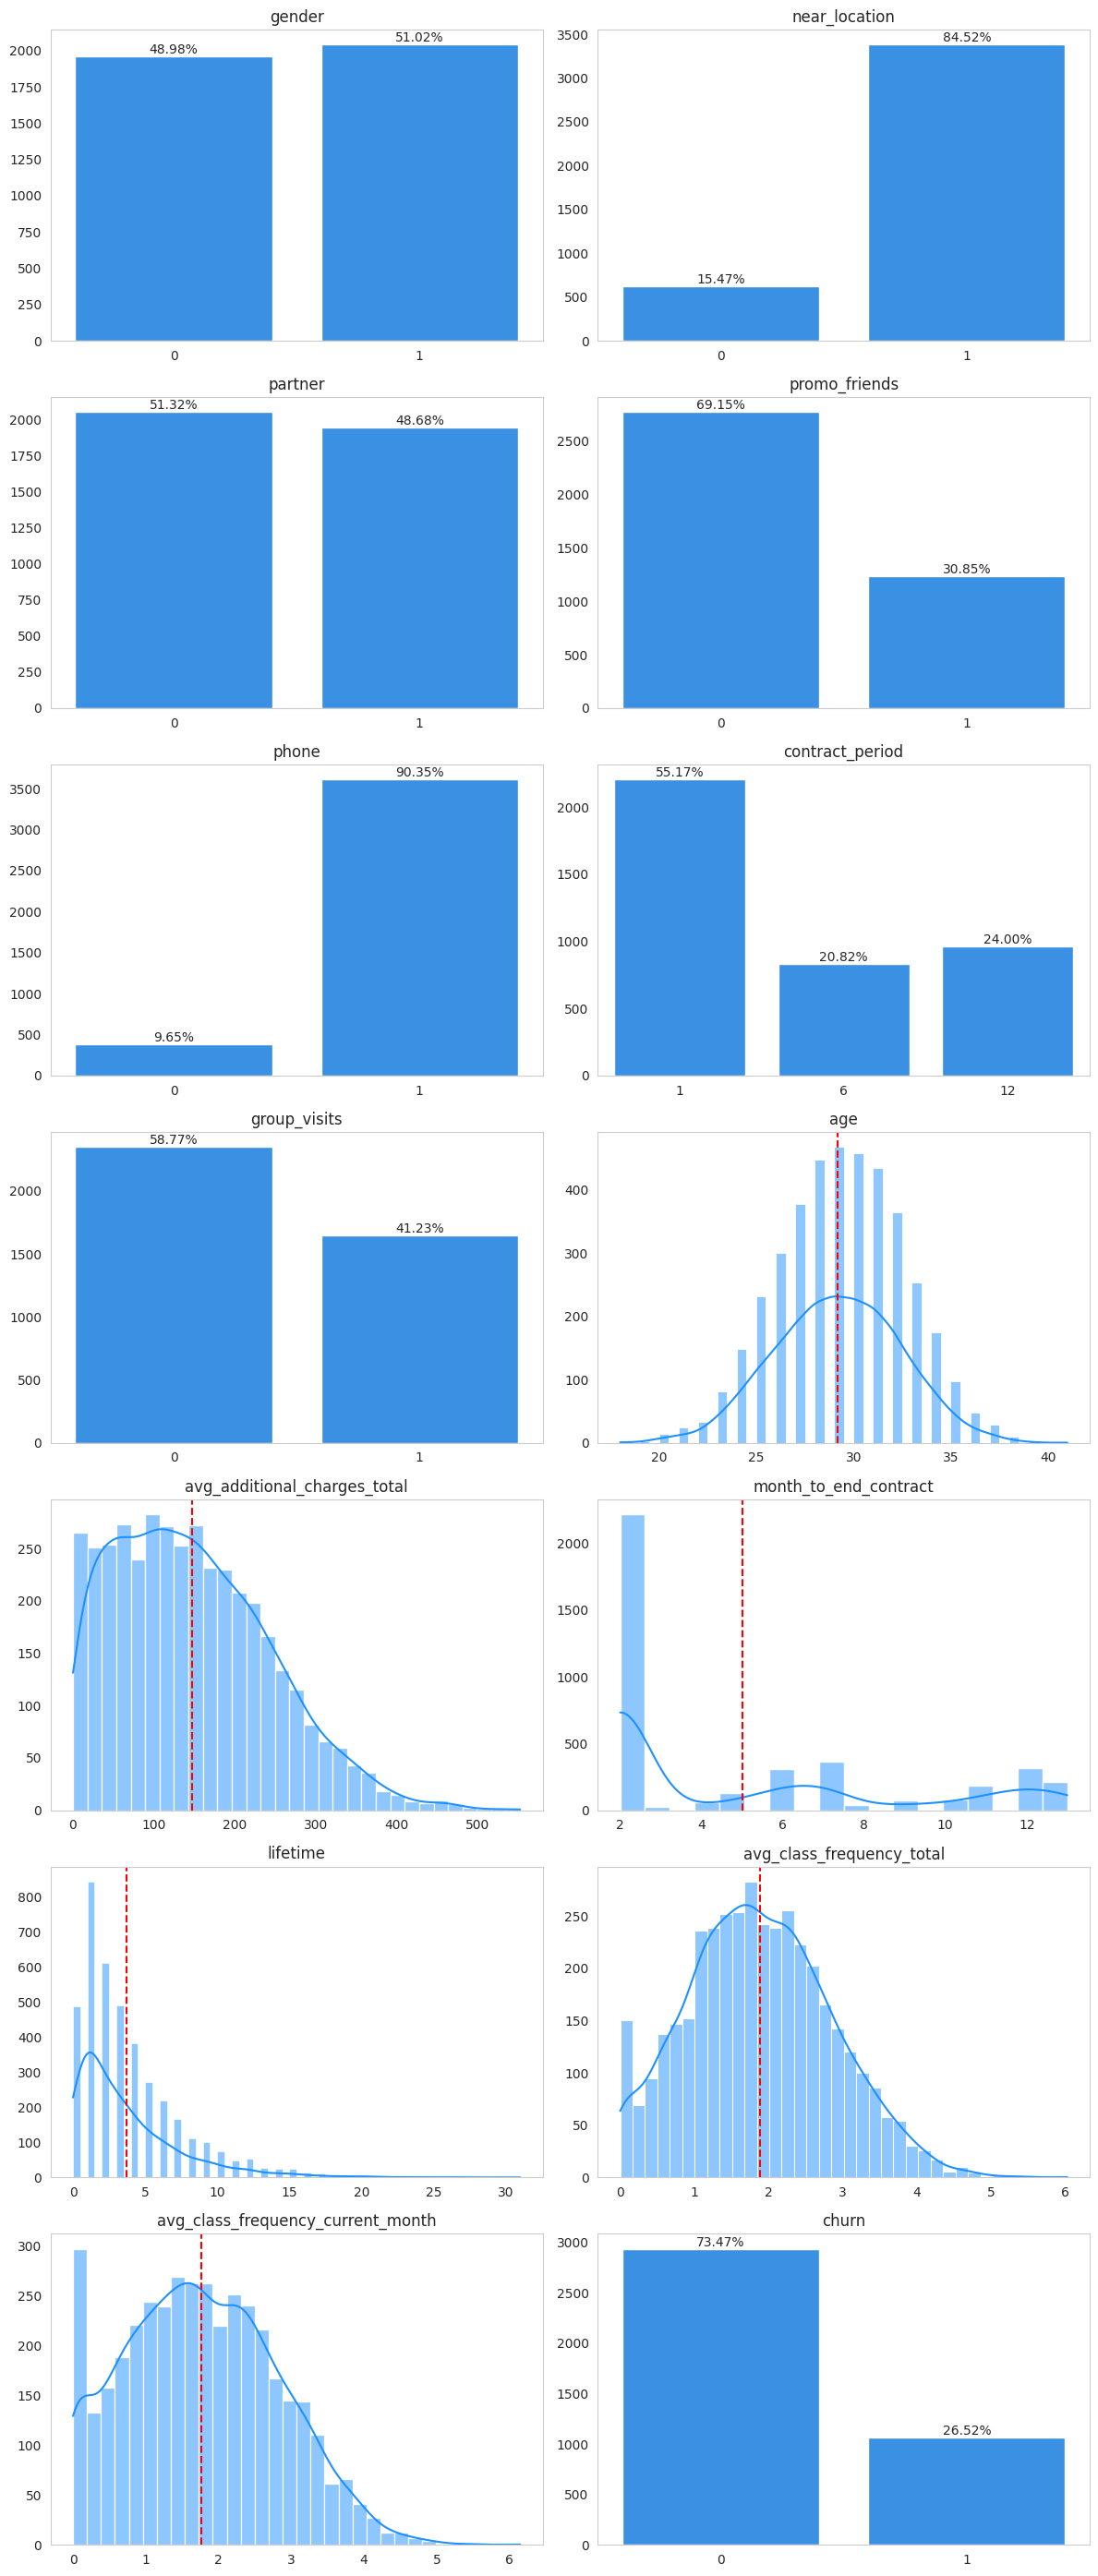

In [116]:
basic_data_preprocessing(data)

Preprocessing results:

1. The dataset contains 4000 records and 14 columns;

2. The dataset consists of various features, including: gender, nearby location, partnership status, promotional activities, phone availability, contract period, group visits, age, additional charges, remaining months in the contract, lifetime, average class frequency, and churn status;

3. All columns in the dataset have 4000 non-null values, indicating no missing data;

4. Some columns have a count of 0, indicating the presence of zero values. These columns include Boolean features: *gender, nearest_location, partner, promo_friends, phone, group_visits, churn*. As well as numerical characteristics that can theoretically be equal to zero: *lifetime, avg_class_frequency_total, avg_class_frequency_current_month*. Thus, the value 0 is not a clear sign of possible missing data in this dataset.;

5. There are no duplicate records in the dataset;

6. There are no negative values in the dataset;

7. Data types are correct but do not match actual data. The data can be compressed to reduce the amount of consumed memory;

8. Data distribution:
- The data is normally distributed in the *'age'*, *'gender'* and *'partner'* features.
- 'near_location': most clients (84.52%) live near fitness centers;
- 'promo_friends': most clients (69.15%) did not participate in the "bring a friend" promotion;
- 'phone': most clients (90%) provide their phone numbers;
- 'contract_period': most clients(55.17%) sign 1 month contract, 24% of clients choose 12 months option, and 20.83 % of clients choose 6 months option;
- 'group_visits': most clients (58.77%) visit fitness centers individually, not as part of a group;
- 'avg_additional_charges_total': data is skewed to the right. It reveals that the majority of fitness center clents tend to make additional charges at a relatively stable level below 150, while a portion of clients gradually reduces their additional charges as the values approach 500. This behavior may indicate a threshold effect or changing preferences among clients regarding additional services offered by the fitness center.
- 'month_to_end_contract': the distribution of data reveals that a significant number of clients (over 2000 people) have approximately 2 months remaining in their current active subscription. This suggests that many clients prefer shorter subscription periods, potentially to have more flexibility in reviewing their needs and subscription terms;
- 'lifetime': data is skewed to the right. It reveals that a significant number of clients have a relatively short time since their first visit, with the majority visiting for 1 or 2 months, and a notable occurrence of visits within the first month (487). However, there is also a presence of long-term clients, with a few individuals having a lifetime exceeding 2 years;
- 'avg_class_frequency_total': The distribution of data suggests that the majority of clients have an average weekly visit frequency that gradually increases from 0 to the mean value (2). However, the distribution is slightly right-skewed as some clients exhibit higher visit frequencies, with a decreasing trend towards 5;
- 'avg_class_frequency_current_month': data is slightly right-skewed. A significant number of clients(over 300 clients) did not visit the fitness center at all in the previous month(0 visits) thtat exhibits a sudden downgrade in visit frequency, likely an outlier or an isolated event;
- 'churn': there is a significant number of customers (1061) who have churned, but the majority still remain active.

In [117]:
# Data compression
data_type_compression(data)

In [118]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int8   
 1   near_location                      4000 non-null   int8   
 2   partner                            4000 non-null   int8   
 3   promo_friends                      4000 non-null   int8   
 4   phone                              4000 non-null   int8   
 5   contract_period                    4000 non-null   int8   
 6   group_visits                       4000 non-null   int8   
 7   age                                4000 non-null   int8   
 8   avg_additional_charges_total       4000 non-null   float16
 9   month_to_end_contract              4000 non-null   int8   
 10  lifetime                           4000 non-null   int8   
 11  avg_class_frequency_total          4000 non-null   float

## Data distribution

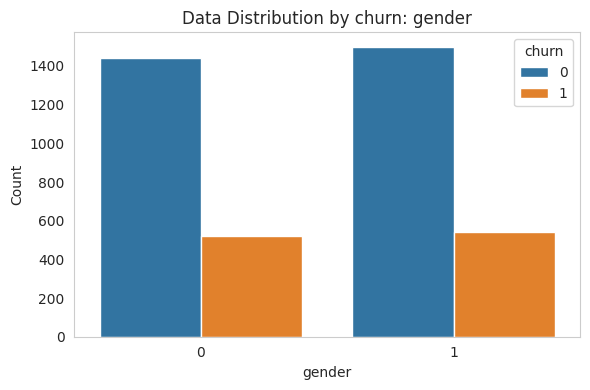

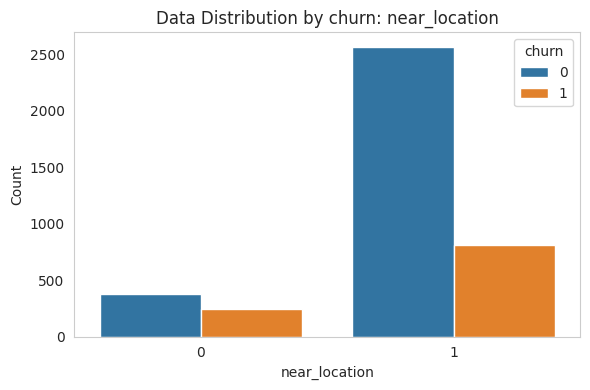

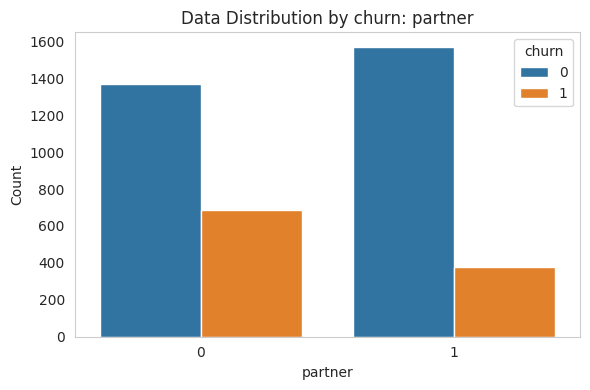

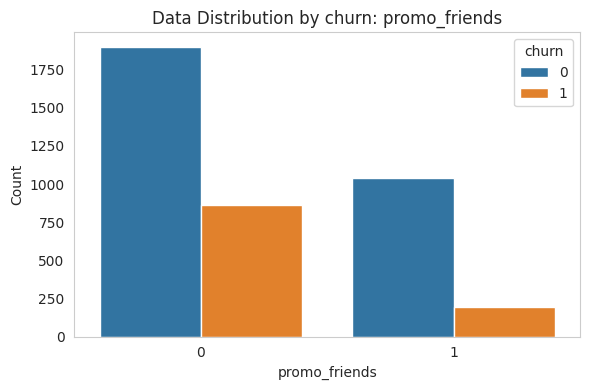

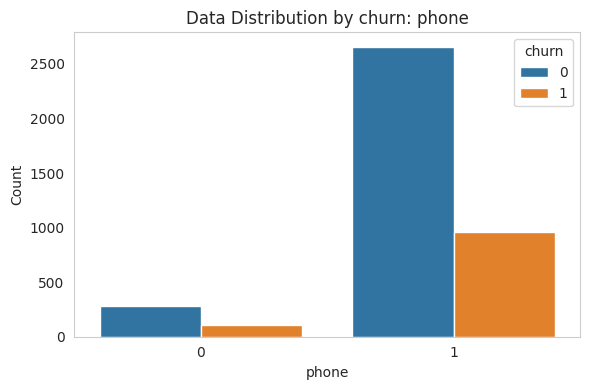

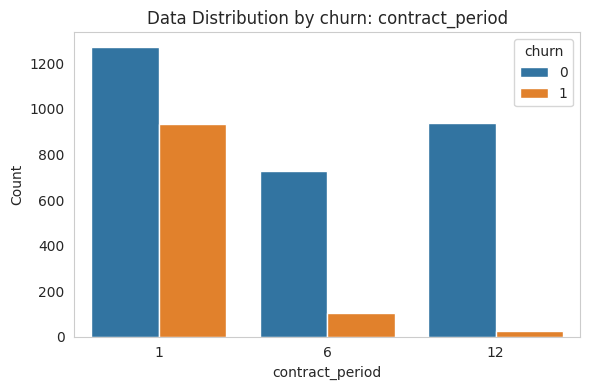

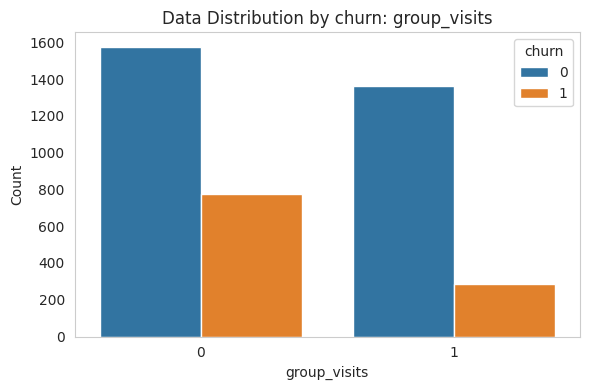

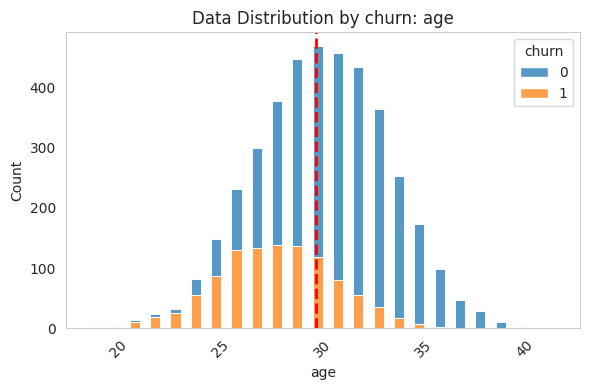

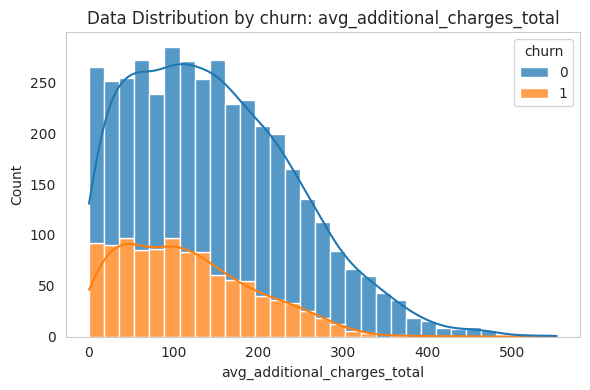

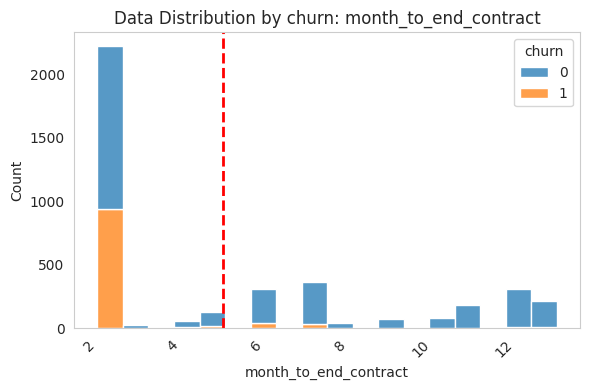

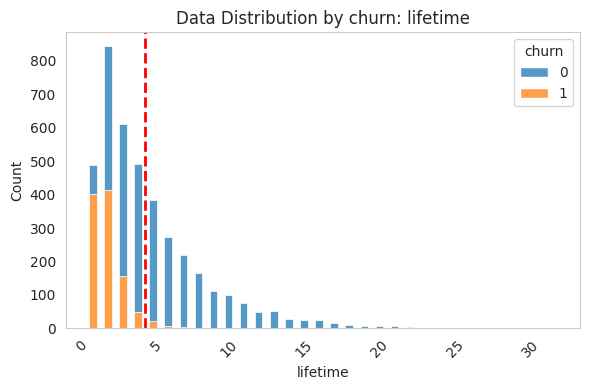

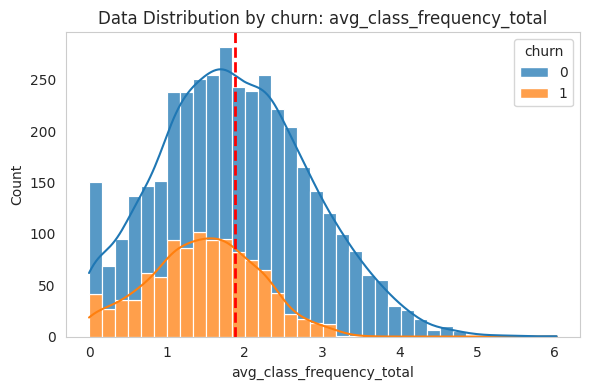

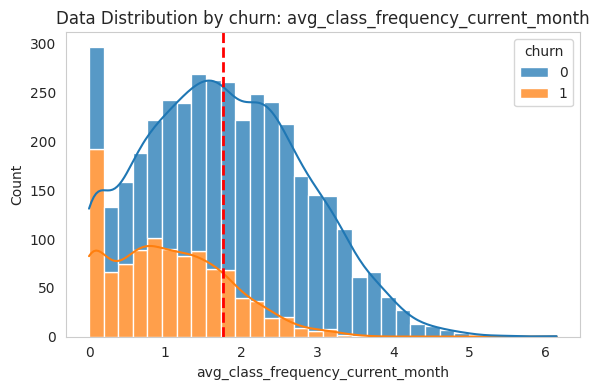

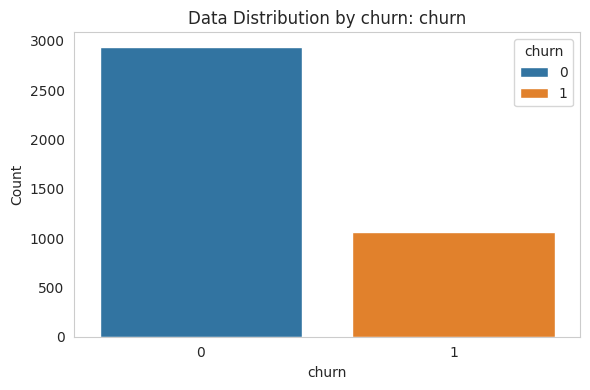

In [13]:
data_distribution_by_target(data, 'churn')

- 'gender': The clients' churn by the feature 'gender' attribute is distributed evenly. Thus, the churn does not depend on the gender of the client. This way this feature can be removed from the dataset;
- 'near_location': More than half of clients who do not live near a fitness center churn. For clients living near fitness centers, this ratio is lower and equals about 30%;
- 'partner': More than 40% of clients visiting the fitness center without partners churn. For clients visiting the fitness center with partners, this ratio is several times lower;
- 'promo_friends': This distribution is similar to the previous one, however, among the clients who participated in the promo, there are even fewer who churn;
- 'phone': The number of churned clients who provided a phone number and did not provide it is approximately the same and is about 40% for each group. Thus, this feature can be removed from the dataset;
- 'contract_period': The largest number of churned clients signed a monthly contract. Clients who signed a 12-month contract were the least likely to churn;
- 'group_visits': Among the clients who train in groups, about 15% churn. Among all clients who are not engaged, about 50% churn;
- 'age': Most of the clients under the age of 26 churn. About half of the clients at the age of 27 churn. Starting with clients aged 28, the number of churns decreases. Thus, the older the clients, the lower the risk that they will churn;
- 'avg_additional_charges_total': The churn of total average additional charges is similar to the general distribution of data according to this feature: up to the level of charges in the amount of 140, the churn remains at approximately the same level, and further decreases with an increase in additional charges;
- 'month_to_end_contract': Almost all of the churned clients had 2 or less months left before the end of the contract;
- 'lifetime': For 80% of the churned clients, the feature 'lifetime' is only 2 months;
- 'avg_class_frequency_total': The churn of total avg class frequency is similar to the general distribution of data according to this feature;
- 'avg_class_frequency_current_month': The churn of current month avg class frequency is similar to the general distribution of data according to this feature.

## Outliers checking

No outliers in column 'gender' as it has binary values.
***************************************************************************

No outliers in column 'near_location' as it has binary values.
***************************************************************************

No outliers in column 'partner' as it has binary values.
***************************************************************************

No outliers in column 'promo_friends' as it has binary values.
***************************************************************************

No outliers in column 'phone' as it has binary values.
***************************************************************************

No outliers in column 'contract_period'.
***************************************************************************

No outliers in column 'group_visits' as it has binary values.
***************************************************************************

Outliers in column 'age':
Outlier Count: 32
Outlier Percentage o

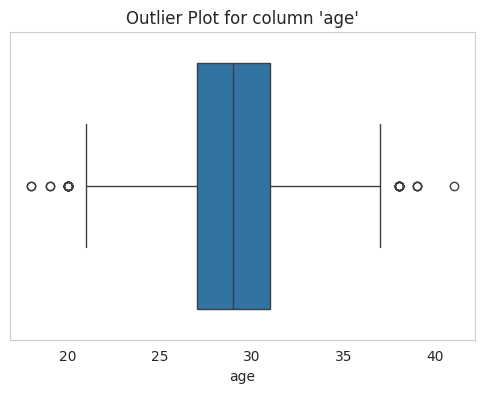

***************************************************************************

Outliers in column 'avg_additional_charges_total':
Outlier Count: 29
Outlier Percentage of total observations: 0.73%
Outlier Values: 450.8, 455.2, 472.2, 461.0, 446.0, 552.5, 457.5, 462.2, 471.8, 456.8, 425.5, 496.2, 464.0, 431.0, 488.8, 440.8, 449.0, 424.2, 432.0, 466.0, 443.0, 515.5, 457.0, 476.5, 434.5, 534.5, 429.5, 429.2, 468.2


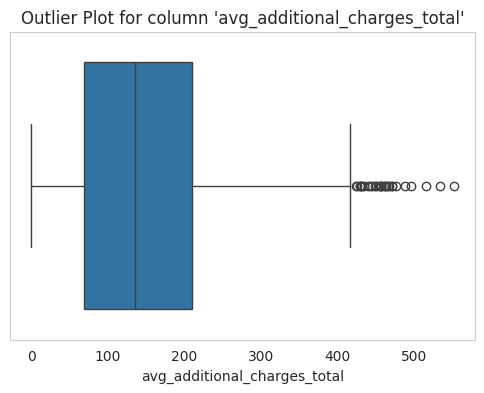

***************************************************************************

No outliers in column 'month_to_end_contract'.
***************************************************************************

Outliers in column 'lifetime':
Outlier Count: 192
Outlier Percentage of total observations: 4.80%
Outlier Values: 14, 15, 12, 21, 12, 12, 12, 12, 20, 12, 12, 13, 15, 17, 12, 13, 12, 13, 16, 17, 14, 17, 20, 15, 13, 12, 12, 14, 12, 15, 12, 17, 13, 24, 14, 22, 14, 13, 14, 12, 12, 31, 21, 26, 14, 12, 14, 15, 23, 14, 14, 22, 16, 17, 18, 12, 12, 13, 20, 16, 14, 19, 16, 19, 14, 15, 12, 14, 15, 19, 12, 12, 12, 17, 16, 12, 18, 17, 12, 21, 21, 12, 13, 16, 12, 17, 13, 13, 12, 20, 14, 12, 13, 15, 13, 27, 16, 14, 13, 13, 13, 13, 12, 15, 13, 12, 12, 13, 15, 18, 13, 18, 12, 26, 15, 15, 18, 13, 19, 12, 15, 14, 12, 20, 15, 14, 16, 14, 13, 15, 19, 16, 14, 12, 12, 17, 12, 12, 16, 29, 15, 19, 13, 16, 12, 14, 15, 15, 12, 13, 12, 13, 14, 17, 12, 12, 18, 13, 17, 12, 14, 13, 15, 15, 12, 19, 24, 12, 16, 13, 12, 2

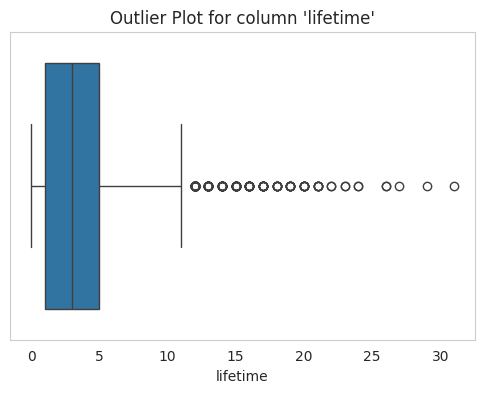

***************************************************************************

Outliers in column 'avg_class_frequency_total':
Outlier Count: 16
Outlier Percentage of total observations: 0.40%
Outlier Values: 5.41, 4.66, 4.7, 4.676, 5.14, 4.7, 4.953, 4.59, 4.793, 6.023, 5.42, 4.777, 4.61, 4.68, 5.08, 4.844


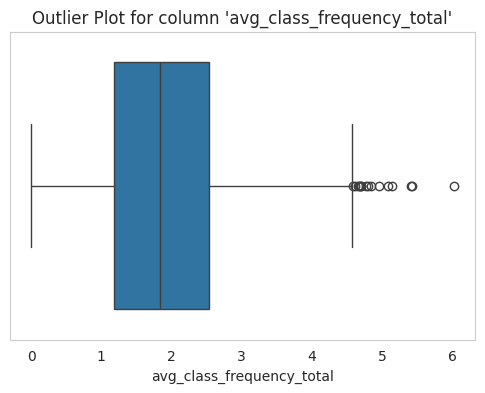

***************************************************************************

Outliers in column 'avg_class_frequency_current_month':
Outlier Count: 8
Outlier Percentage of total observations: 0.20%
Outlier Values: 5.367, 4.96, 4.91, 6.15, 5.457, 5.023, 4.977, 4.926


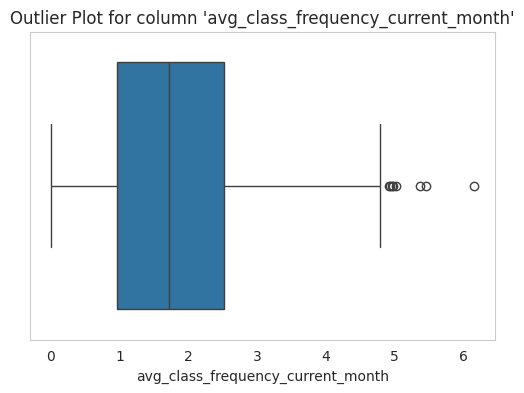

***************************************************************************

No outliers in column 'churn' as it has binary values.
***************************************************************************



,Column,Outlier Count,Outlier Percentage
0,gender,NaN,NaN
1,near_location,NaN,NaN
2,partner,NaN,NaN
3,promo_friends,NaN,NaN
4,phone,NaN,NaN
5,contract_period,0,0
6,group_visits,NaN,NaN
7,age,32,0.8
8,avg_additional_charges_total,29,0.725
9,month_to_end_contract,0,0


In [14]:
detect_outliers(data)

The analysis results show that some columns contain outliers:

1. Column 'age': has 32 outliers, which is approximately 0.8% of the total number of records;
2. Column 'avg_additional_charges_total': has 29 outliers, which is approximately 0.725% of the total number of entries;
3. Column 'lifetime': has 192 outliers, which is approximately 4.8% of the total number of entries;
4. Column 'avg_class_frequency_total': has 16 outliers, which is approximately 0.4% of the total number of records;
5. Column 'avg_class_frequency_current_month': has 8 outliers, which is approximately 0.2% of the total number of records.

However, the percentage of outliers is small and therefore they will probably not have a significant impact on the overall performance of the models.

## Correlation

<ipython-input-5-4d96b245bba4>:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=75)
<ipython-input-5-4d96b245bba4>:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=75)


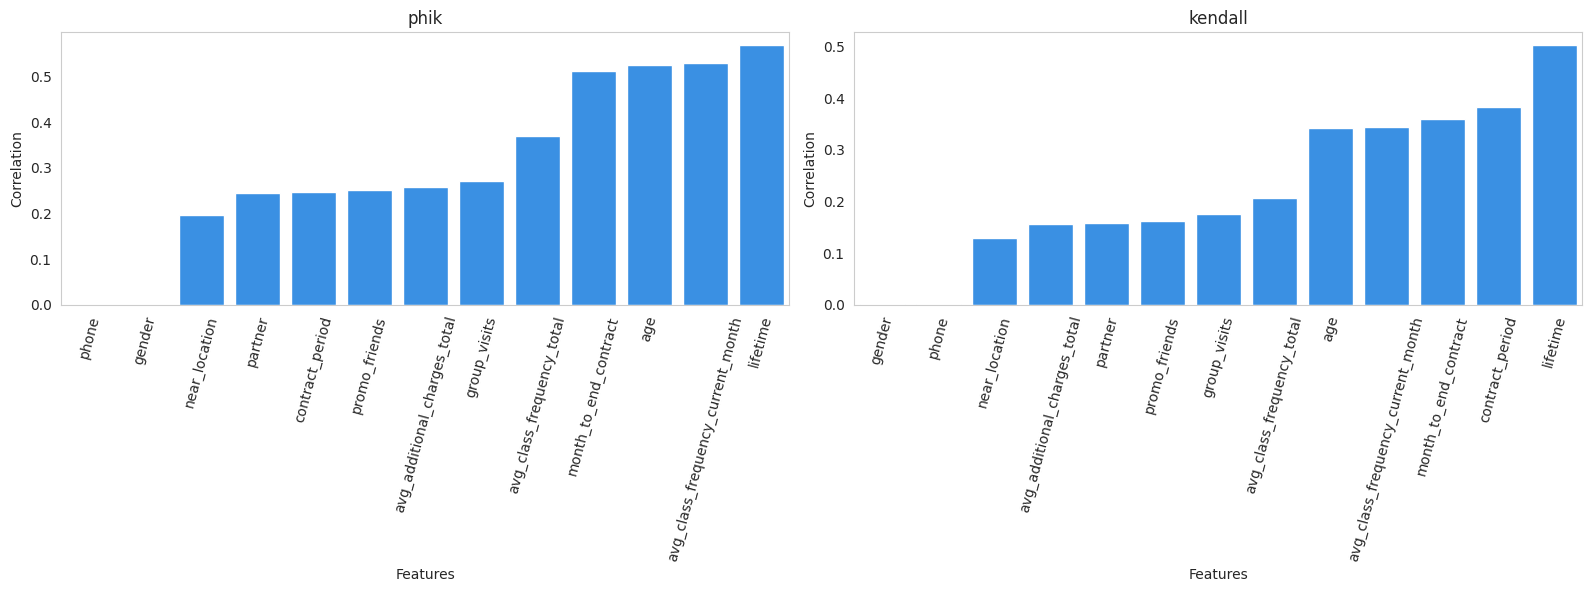

Correlation table with target feature 'churn':


Correlation Type,phik,kendall
Column,,
lifetime,0.568174,0.502351
avg_class_frequency_current_month,0.528021,0.343647
age,0.524050,0.341556
month_to_end_contract,0.512427,0.359973
avg_class_frequency_total,0.369990,0.206769
group_visits,0.270011,0.175325
avg_additional_charges_total,0.258145,0.156348
promo_friends,0.250009,0.162233
contract_period,0.247718,0.382994



Top 2 features with highest correlation (Phik): ['lifetime', 'avg_class_frequency_current_month']

Top 2 features with highest correlation (Kendall): ['lifetime', 'contract_period']


In [15]:
correlation_types=['phik', 'kendall']
# 'kendall'
correlation_analysis(data, 'churn', correlation_types=correlation_types, apply_abs=True)

The results of the correlation analysis:

1. According to 'phi-k' correlation he features 'lifetime' (0.568174), 'avg_class_frequency_current_month' (0.528021), and 'age' (0.524050) show the highest positive correlation with the target feature('churn'). This means that the longer the time since the first visit, the more frequently the client attends in the last month, and the older the client, the lower the likelihood of churn.

2. There is also a significant correlation between the target variable and the features 'month_to_end_contract' (0.512427) and 'avg_class_frequency_total' (0.369990). This indicates that customers who have fewer months remaining in their contract and who attend classes less frequently on average are more likely to churn.

3. The features 'group_visits' (0.270011), 'avg_additional_charges_total' (0.258145), and 'promo_friends' (0.250009) show the least significant correlation with churn.

4. The 'phone' and 'gender' features have no correlation with the target variable and can be considered for removal from the dataset as they do not provide significant predictive power.

Based on these results, gradient boosting models (e.g., XGBoost or LightGBM) can be used to train a churn prediction model.

In addition, it is also possible to consider other models, such as random forests or logistic regression, and compare their effectiveness.



---

Let's check the variables for multicollinear relationships

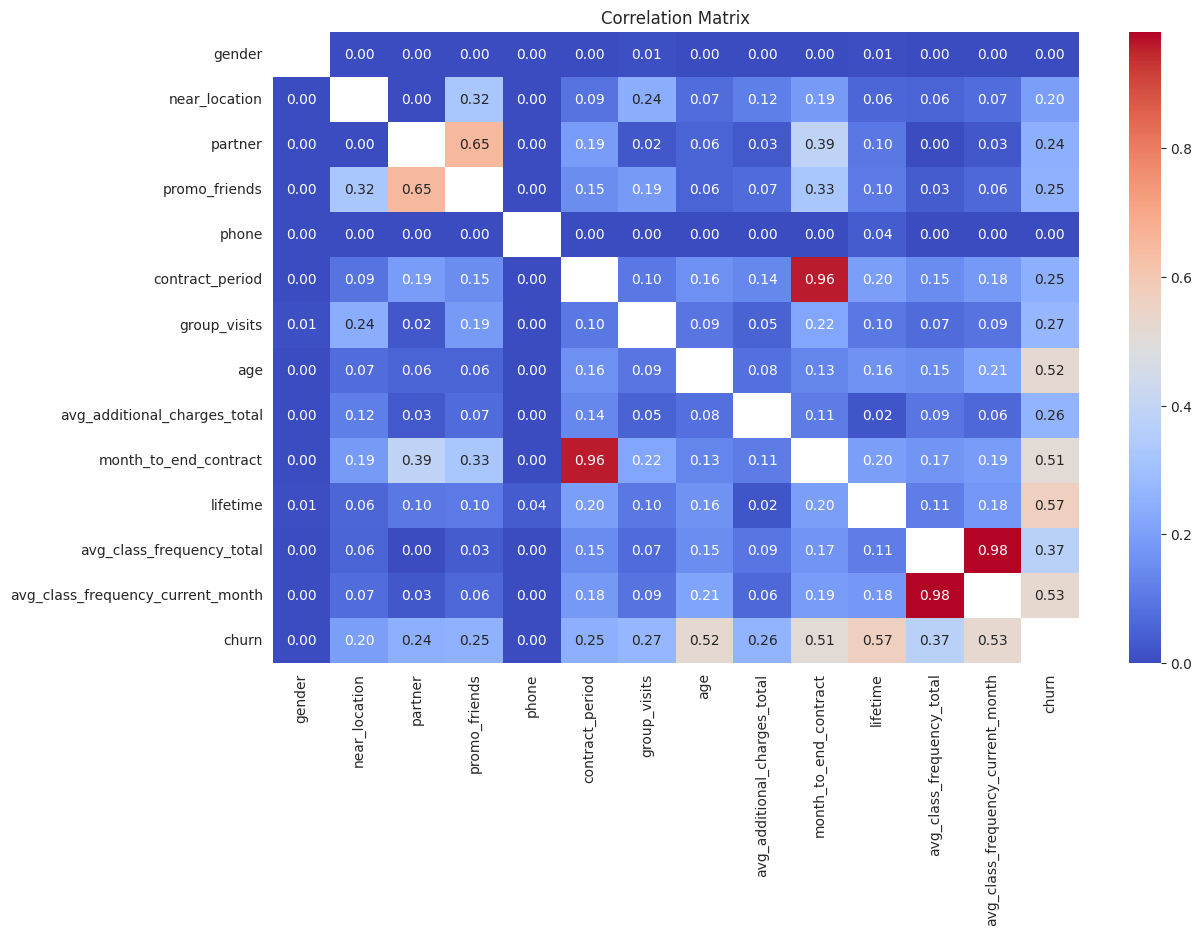

,Feature 1,Feature 2,Correlation
1,avg_class_frequency_total,avg_class_frequency_current_month,0.980243
0,contract_period,month_to_end_contract,0.957403


In [16]:
find_multicollinearity(data, sort_method='phik', threshold=0.7)

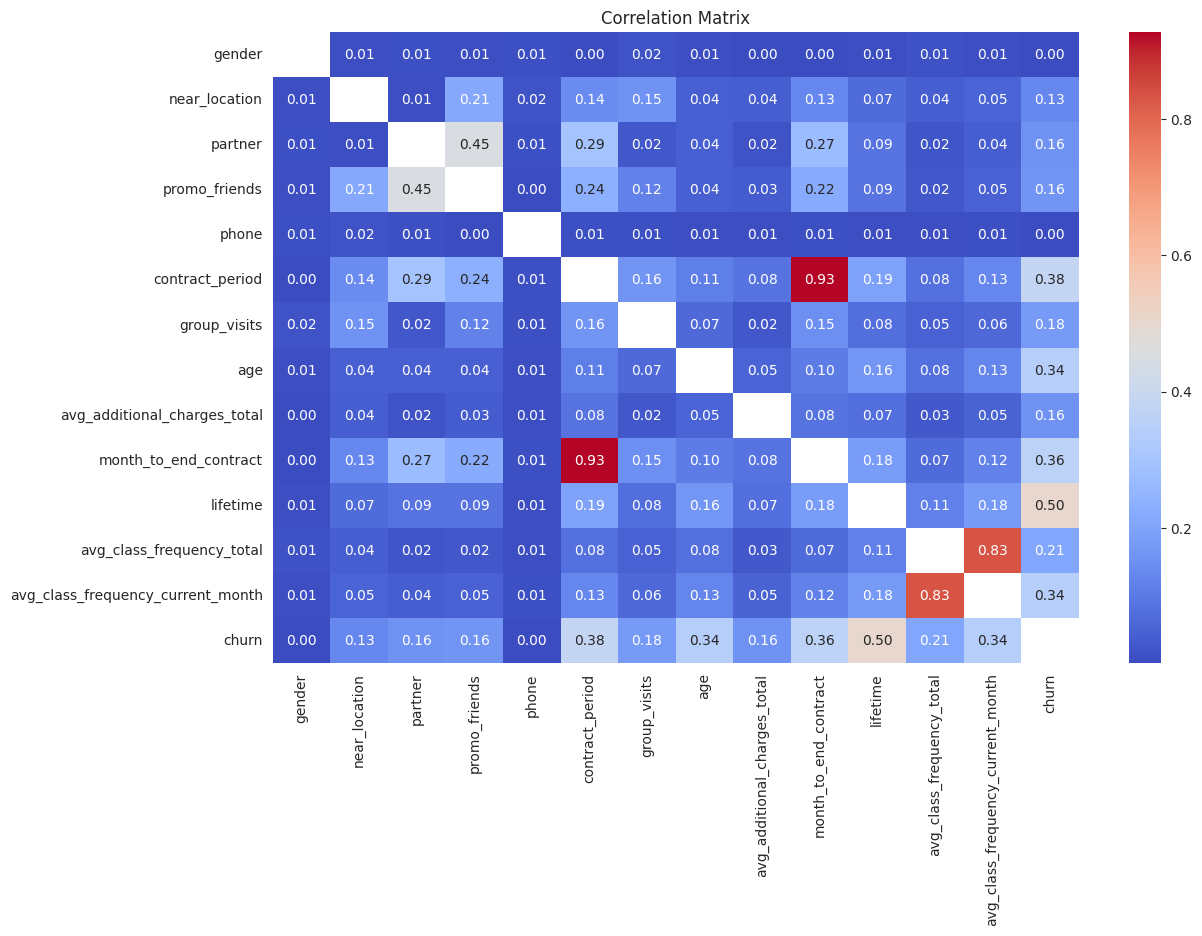

,Feature 1,Feature 2,Correlation
0,contract_period,month_to_end_contract,0.928435
1,avg_class_frequency_total,avg_class_frequency_current_month,0.832219


In [17]:
find_multicollinearity(data, sort_method='kendall', threshold=0.7)



---



The features 'contract_period - month_to_end_contract' and
'avg_class_frequency_total - avg_class_frequency_current_month' show a very strong correlation between each other(over 95%). It is worth removing one of the correlated signs to train models.

Based on the correlation and multicollinearity information, the most optimal solution is to remove the following features from the dataset: *'avg_class_frequency_total'* and *'contract_period'*.


## Summary

The initial dataset contains **4000 records** and **14 columns**. **There are no missing values or duplicates** in the dataset. **The data types are correct** but were compressed to reduce memory consumption.

Based on the analysis of data distribution in relation to the churn status, the preliminary client portrait who is more likely to churn can be described as follows:

- **Gender:** The churn is evenly distributed among clients based on the gender attribute. Gender does not seem to have a significant impact on churn, so this feature **can be removed from the dataset**.
-** Proximity to Fitness Center:** Clients who do not live near a fitness center are more likely to churn, with churn rates exceeding 50%. For clients living near fitness centers, the churn rate is lower, at around 30%.
- **Partnership status:** More than 40% of clients who visit the fitness center without partners churn. In contrast, clients visiting the fitness center with partners have a significantly lower churn rate.
- **Promotion through Friends:** The churn rate follows a similar pattern as the partnership status. Clients who participated in the promotion through friends have an even lower churn rate compared to those who did not participate.
- **Phone Availability:** The churn rate is approximately the same for clients who provided a phone number and those who did not, at around 40%. Therefore, this feature **can be removed from the dataset**.
- **Contract Period:** Clients who signed a monthly contract have a higher churn rate compared to those who signed a longer contract. Clients with a 12-month contract have the lowest churn rate.
- **Group Visits:** Clients who train in groups have a lower churn rate, at around 15%. In contrast, clients who do not participate in group visits have a significantly higher churn rate of approximately 50%.
- **Age:** Clients who are younger have a higher likelihood of churning. The churn rate is highest among clients under the age of 26 and decreases as age increases. Older clients have a lower risk of churning.
- **Average Additional Charges:** The churn rate for total average additional charges follows a similar distribution as the general data. Clients with additional charges below 140 have a relatively higher churn rate, which decreases as additional charges increase.
- **Remaining Months in Contract:** Almost all churned clients have 2 or fewer months remaining before the end of their contract. This suggests that clients with shorter remaining contract periods are more likely to churn.
- **Lifetime:** For 80% of churned clients, their lifetime is only 2 months. This indicates that clients who have been with the fitness center for a shorter time are more likely to churn.
- **Average Class Frequency:** The churn rate for both total average class frequency and current month average class frequency follows a similar distribution as the general data.

---

The clinet who is more likely to leave the fitness center is likely to have the following characteristics:
- Has 2 months or less remaining in their contract.
- Does not participate in group visits.
- Is under the age of 26.
- Has a low level of average additional charges.
- Has a lifetime of only 2 months since their first visit.
- Has a low average class frequency per week (both in general and in the current month).

However, it is important to note that this is a preliminary client portrait, and other factors may also influence a client's decision to leave the fitness center.


---

The analysis reveals the presence of outliers in several columns:

- 'age' column has 32 outliers, approximately 0.8% of the total number of records.
- 'avg_additional_charges_total' column has 29 outliers, approximately 0.725% of the total number of records.
- 'lifetime' column has 192 outliers, approximately 4.8% of the total number of records.
- 'avg_class_frequency_total' column has 16 outliers, approximately 0.4% of the total number of records.
- 'avg_class_frequency_current_month' column has 8 outliers, approximately 0.2% of the total number of records.

However, the percentage of outliers in these columns is relatively small, indicating that they are unlikely to have a significant impact on the overall performance of the predictive models. Thus, these outliers can be considered acceptable for further analysis and modeling.


---

The correlation analysis highlights the following key findings:

- The features **'lifetime', 'avg_class_frequency_current_month'**, and **'age'** exhibit the highest correlation with the target feature 'churn'. This suggests that longer time since the first visit, higher frequency of visits in the last month, and older age decrease the likelihood of churn.

- The features **'month_to_end_contract'** and **'avg_class_frequency_total'** also demonstrate a significant correlation with churn. This implies that customers with fewer months remaining in their contract and lower average class frequency are more likely to churn.

- The features 'group_visits', 'avg_additional_charges_total', and 'promo_friends' display minimal correlation with churn.

- The features **'phone'** and **'gender'** show no correlation with the target variable, indicating that their inclusion may not significantly contribute to predicting churn.

- Strong multicollinearity exists between the features 'contract_period' and 'month_to_end_contract', as well as between 'avg_class_frequency_total' and 'avg_class_frequency_current_month'. Removing one of the correlated variables is advisable to address this issue.

Based on these insights, gradient boosting models like XGBoost or LightGBM can be appropriate for building a churn prediction model.






---



As a result of the analysis, it was decided to remove the following features from the dataset for effective model training:
- **'gender'**;
- **'phone'**;
- **'avg_class_frequency_total'**;
- **'contract_period'**.

# Model Training

In [119]:
import sklearn
from sklearn import linear_model
from sklearn import metrics
from sklearn import model_selection
from sklearn import tree

In [138]:
df = data.copy()

In [139]:
# Drop columns
columns_to_drop = ['gender', 'phone', 'avg_class_frequency_total', 'contract_period']

df.drop(columns=columns_to_drop, axis=1, inplace=True)
df.head(3)

,near_location,partner,promo_friends,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_current_month,churn
0,1,1,1,1,29,14.226562,5,3,0.000000,0
1,1,0,0,1,31,113.187500,13,7,1.910156,0
2,1,1,0,0,28,129.500000,2,2,1.736328,0


In [160]:
# Сreate a dataframe for storing trained models results

models_df = pd.DataFrame(columns=['Model', 'Recall', 'Training time', 'Special model parameters'])

In [141]:
X = df.drop('churn', axis=1)
y = df['churn']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True)
X.head(3)

,near_location,partner,promo_friends,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_current_month
0,1,1,1,1,29,14.226562,5,3,0.000000
1,1,0,0,1,31,113.187500,13,7,1.910156
2,1,1,0,0,28,129.500000,2,2,1.736328


Next, let's standardize the data to ensure comparable scales and statistical properties across different features, leading to improved performance and generalizability of machine learning models.

In [124]:
from sklearn.preprocessing import StandardScaler

# Create an instance of StandardScaler
scaler = StandardScaler()

# Standardize the training data
X_train_scaled = scaler.fit_transform(X_train)

# Standardize the test data
X_test_scaled = scaler.transform(X_test)

## Baseline models

### LogisticRegression

In [161]:
from sklearn.linear_model import LogisticRegression

# Create a pipeline with StandardScaler for LogisticRegression
lr_base = LogisticRegression(random_state=42)

#Cross-validation to evaluate the model
y_train_predict = model_selection.cross_val_predict(estimator=lr_base, X=X_train, y=y_train, cv=5)
y_test_predict = model_selection.cross_val_predict(estimator=lr_base, X=X_test, y=y_test, cv=5)

# Calculate the recall score
recall_train = metrics.recall_score(y_train, y_train_predict)
recall_test = metrics.recall_score(y_test, y_test_predict)

# Use cross_validate to perform cross-validation and get scores for multiple metrics
scores = model_selection.cross_validate(lr_base, X_train, y_train, cv=5, scoring='recall', return_train_score=True)

# Calculate the average fit time across different cross-validation folds
fit_time_mean = round(np.mean(scores['fit_time']), 2)


print(f"Average fit time: {fit_time_mean} seconds")
print('-' * 40)
print(f"Train Recall: {recall_train}")
print(f"Test Recall: {recall_test}")

Average fit time: 0.05 seconds
----------------------------------------
Train Recall: 0.806930693069307
Test Recall: 0.8023715415019763


In [162]:
# Create a temporary dataframe with trained models results
temp_df = pd.DataFrame({'Model': ['lr_base'],
                        'Recall': [recall_test],
                        'Training time': [fit_time_mean],
                        })
models_df = pd.concat([models_df, temp_df], ignore_index=True)

models_df

,Model,Recall,Training time,Special model parameters
0,lr_base,0.802372,0.05,NaN


### GradientBoostingClassifier

In [163]:
from sklearn.ensemble import GradientBoostingClassifier

gb_base =  GradientBoostingClassifier(random_state=42)

#Cross-validation to evaluate the model
y_train_predict = model_selection.cross_val_predict(estimator=gb_base, X=X_train, y=y_train, cv=5)
y_test_predict = model_selection.cross_val_predict(estimator=gb_base, X=X_test, y=y_test, cv=5)

# Calculate the recall score
recall_train = metrics.recall_score(y_train, y_train_predict)
recall_test = metrics.recall_score(y_test, y_test_predict)

# Use cross_validate to perform cross-validation and get scores for multiple metrics
scores = model_selection.cross_validate(gb_base, X_train, y_train, cv=5, scoring='recall', return_train_score=True)

# Calculate the average fit time across different cross-validation folds
fit_time_mean = round(np.mean(scores['fit_time']), 2)


print(f"Average fit time: {fit_time_mean} seconds")
print('-' * 40)
print(f"Train Recall: {recall_train}")
print(f"Test Recall: {recall_test}")

Average fit time: 0.37 seconds
----------------------------------------
Train Recall: 0.7970297029702971
Test Recall: 0.766798418972332


In [164]:
# Create a temporary dataframe with trained models results
temp_df = pd.DataFrame({'Model': ['gb_base'],
                        'Recall': [recall_test],
                        'Training time': [fit_time_mean],
                        })
models_df = pd.concat([models_df, temp_df], ignore_index=True)

models_df

,Model,Recall,Training time,Special model parameters
0,lr_base,0.802372,0.05,NaN
1,gb_base,0.766798,0.37,NaN


## Models tuning

Based on the results of building baseline models, the logistic regression model predicts more accurate results, but the prediction accuracy is not high enough. Let's try to choose the optimal hyperparameters for both models.

### LogisticRegression

In [148]:
from sklearn.model_selection import GridSearchCV
import warnings

warnings.filterwarnings("ignore")

lr = linear_model.LogisticRegression(random_state=42, max_iter=1000)

# Defining a grid of parameters to iterate through
param_grid = {
    'C': [0.001, 0.01, 0.1, 0.95],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['liblinear', 'sag', 'saga'],
    'fit_intercept': [True, False],
    'class_weight': ['balanced', None]
}

grid_search = GridSearchCV(lr, param_grid, scoring='recall', cv=5)

# Starting the search for optimal parameters
grid_search.fit(X_train, y_train)

# Getting the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("BEST PARAMETRS:", best_params)
print("BEST SCORE:", best_score)

BEST PARAMETRS: {'C': 0.95, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'solver': 'liblinear'}
BEST SCORE: 0.9245456636760985


Let's train the model according to the best parameters

In [165]:
# Create a LogisticRegression the best parameters

bestparams = best_params
lr_best = LogisticRegression(**bestparams)


#Cross-validation to evaluate the model
y_train_predict = model_selection.cross_val_predict(estimator=lr_best, X=X_train, y=y_train, cv=5)
y_test_predict = model_selection.cross_val_predict(estimator=lr_best, X=X_test, y=y_test, cv=5)

# Calculate the recall score
recall_train = metrics.recall_score(y_train, y_train_predict)
recall_test = metrics.recall_score(y_test, y_test_predict)

# Use cross_validate to perform cross-validation and get scores for multiple metrics
scores = model_selection.cross_validate(lr_best, X_train, y_train, cv=5, scoring='recall', return_train_score=True)

# Calculate the average fit time across different cross-validation folds
fit_time_mean = round(np.mean(scores['fit_time']), 2)


print(f"Average fit time: {fit_time_mean} seconds")
print('-' * 40)
print(f"Train Recall: {recall_train}")
print(f"Test Recall: {recall_test}")

Average fit time: 0.13 seconds
----------------------------------------
Train Recall: 0.9245049504950495
Test Recall: 0.9367588932806324


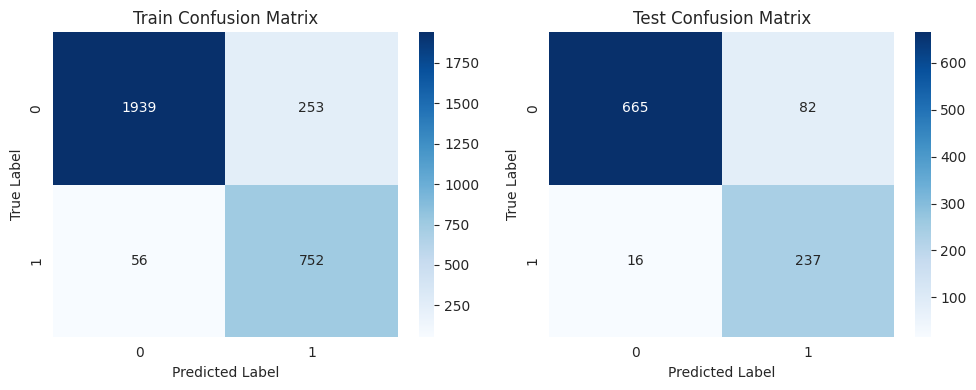

In [151]:
from sklearn.metrics import confusion_matrix

lr_best.fit(X_train, y_train)

# Prediction for the training sample
lr_best_train = lr_best.predict(X_train)
# Prediction for the testing sample
lr_best_pred = lr_best.predict(X_test)


cm_train = confusion_matrix(y_train, lr_best_train)
cm_test = confusion_matrix(y_test, lr_best_pred)

# Plot the confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0])
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[0].set_title('Train Confusion Matrix')
axes[1].set_title('Test Confusion Matrix')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
plt.tight_layout()
plt.show()

In [154]:
report_train = metrics.classification_report(y_train, y_train_predict)
report_test = metrics.classification_report(y_test, y_test_predict)

print('Train\n', report_train)
print('--' * 27)
print('Test\n', report_test)

Train
               precision    recall  f1-score   support

           0       0.97      0.88      0.92      2192
           1       0.74      0.92      0.82       808

    accuracy                           0.89      3000
   macro avg       0.86      0.90      0.87      3000
weighted avg       0.91      0.89      0.90      3000

------------------------------------------------------
Test
               precision    recall  f1-score   support

           0       0.98      0.89      0.93       747
           1       0.75      0.94      0.83       253

    accuracy                           0.90      1000
   macro avg       0.86      0.91      0.88      1000
weighted avg       0.92      0.90      0.91      1000



In [166]:
# Create a temporary dataframe with trained models results
temp_df = pd.DataFrame({'Model': ['lr_best'],
                        'Recall': [recall_test],
                        'Training time': [fit_time_mean],
                        'Special model parameters': ["'C': 0.01, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l1', 'solver': 'liblinear'"]
                        })
models_df = pd.concat([models_df, temp_df], ignore_index=True)

models_df

,Model,Recall,Training time,Special model parameters
0,lr_base,0.802372,0.05,NaN
1,gb_base,0.766798,0.37,NaN
2,lr_best,0.936759,0.13,"'C': 0.01, 'class_weight': 'balanced', 'fit_in..."


### GradientBoostingClassifier

In [59]:
from sklearn.model_selection import GridSearchCV


gb =  GradientBoostingClassifier(random_state=42)

# Defining a grid of parameters to iterate through
param_grid = {
    'n_estimators': [100, 300, 500, 1000],
    'learning_rate': [0.001, 0.01, 0.1, 1],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.8, 1.0]
}


grid_search = GridSearchCV(gb, param_grid, scoring='recall', cv=5)

# Starting the search for optimal parameters
grid_search.fit(X_train, y_train)

# Getting the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("BEST PARAMETRS:", best_params)
print("BEST SCORE:", best_score)

BEST PARAMETRS: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
BEST SCORE: 0.8070086649796794


In [167]:
# Create a LogisticRegression the best parameters

bestparams = best_params
gb_best = GradientBoostingClassifier(**bestparams)

#Cross-validation to evaluate the model
y_train_predict = model_selection.cross_val_predict(estimator=gb_best, X=X_train, y=y_train, cv=5)
y_test_predict = model_selection.cross_val_predict(estimator=gb_best, X=X_test, y=y_test, cv=5)

# Calculate the recall score
recall_train = metrics.recall_score(y_train, y_train_predict)
recall_test = metrics.recall_score(y_test, y_test_predict)

# Use cross_validate to perform cross-validation and get scores for multiple metrics
scores = model_selection.cross_validate(gb_best, X_train, y_train, cv=5, scoring='recall', return_train_score=True)

# Calculate the average fit time across different cross-validation folds
fit_time_mean = round(np.mean(scores['fit_time']), 2)


print(f"Average fit time: {fit_time_mean} seconds")
print('-' * 40)
print(f"Train Recall: {recall_train}")
print(f"Test Recall: {recall_test}")

Average fit time: 0.87 seconds
----------------------------------------
Train Recall: 0.7982673267326733
Test Recall: 0.7628458498023716


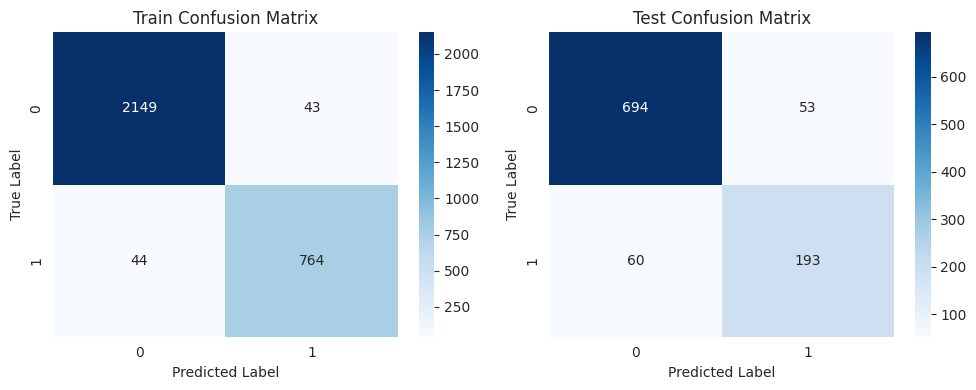

In [169]:
from sklearn.metrics import confusion_matrix

gb_best.fit(X_train, y_train)

# Prediction for the training sample
gb_best_train = gb_best.predict(X_train)
# # Prediction for the testing sample
gb_best_pred = gb_best.predict(X_test)


cm_train = confusion_matrix(y_train, gb_best_train)
cm_test = confusion_matrix(y_test, gb_best_pred)

# Plot the confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0])
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[0].set_title('Train Confusion Matrix')
axes[1].set_title('Test Confusion Matrix')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
plt.tight_layout()
plt.show()

In [168]:
report_train = metrics.classification_report(y_train, y_train_predict)
report_test = metrics.classification_report(y_test, y_test_predict)

print('Train\n', report_train)
print('--' * 27)
print('Test\n', report_test)

Train
               precision    recall  f1-score   support

           0       0.93      0.94      0.93      2192
           1       0.84      0.80      0.82       808

    accuracy                           0.90      3000
   macro avg       0.88      0.87      0.88      3000
weighted avg       0.90      0.90      0.90      3000

------------------------------------------------------
Test
               precision    recall  f1-score   support

           0       0.92      0.93      0.93       747
           1       0.80      0.76      0.78       253

    accuracy                           0.89      1000
   macro avg       0.86      0.85      0.85      1000
weighted avg       0.89      0.89      0.89      1000



In [170]:
# Create a temporary dataframe with trained models results
temp_df = pd.DataFrame({'Model': ['gb_best'],
                        'Recall': [recall_test],
                        'Training time': [fit_time_mean],
                        'Special model parameters': ["'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8"]
                        })
models_df = pd.concat([models_df, temp_df], ignore_index=True)

models_df

,Model,Recall,Training time,Special model parameters
0,lr_base,0.802372,0.05,NaN
1,gb_base,0.766798,0.37,NaN
2,lr_best,0.936759,0.13,"'C': 0.01, 'class_weight': 'balanced', 'fit_in..."
3,gb_best,0.762846,0.87,"'learning_rate': 0.1, 'max_depth': 5, 'n_estim..."


# Model Testing

In [171]:
lr_best.fit(X_train, y_train)

lr_best_train = lr_best.predict(X_train)
lr_best_pred = lr_best.predict(X_test)

recall_train = metrics.recall_score(y_train, lr_best_train)
recall_test = metrics.recall_score(y_test, lr_best_pred)
print(f"Train Recall: {recall_train}")
print(f"Test Recall: {recall_test}")

Train Recall: 0.9306930693069307
Test Recall: 0.9367588932806324


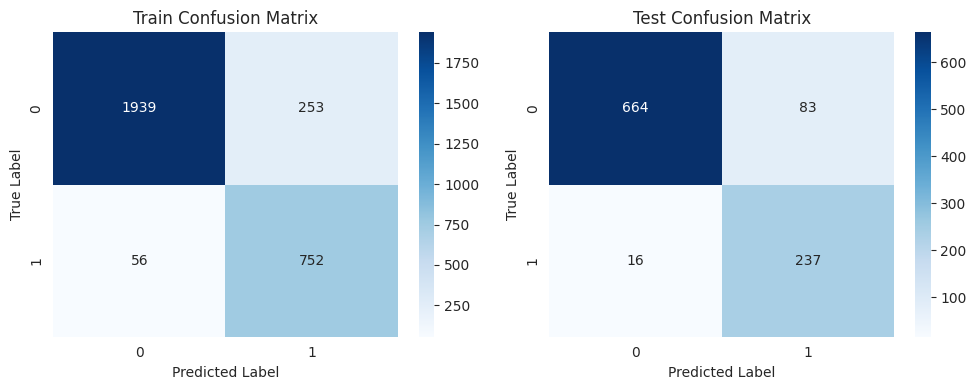

In [172]:
from sklearn.metrics import confusion_matrix

cm_train = confusion_matrix(y_train, lr_best_train)
cm_test = confusion_matrix(y_test, lr_best_pred)

# Plot the confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0])
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[0].set_title('Train Confusion Matrix')
axes[1].set_title('Test Confusion Matrix')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
plt.tight_layout()
plt.show()

The recall for class 1 is 0.94, indicating that the model identifies 94% of the churn customers accurately.

Saving the model for future use

In [173]:
import pickle

# Save the model to a file
filename = 'linear_regression_model.sav'
pickle.dump(lr_best, open(filename, 'wb'))

print("Model successfully saved.")

Model successfully saved.


In [ ]:
# # Load the model from file


# loaded_model = pickle.load(open(filename, 'rb'))

# # Use the loaded model for predictions
# y_pred = loaded_model.predict(X_test)